Loaded 10610 images
Dataset shape: X=(10610, 32, 32, 3), y_dict keys=['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
  

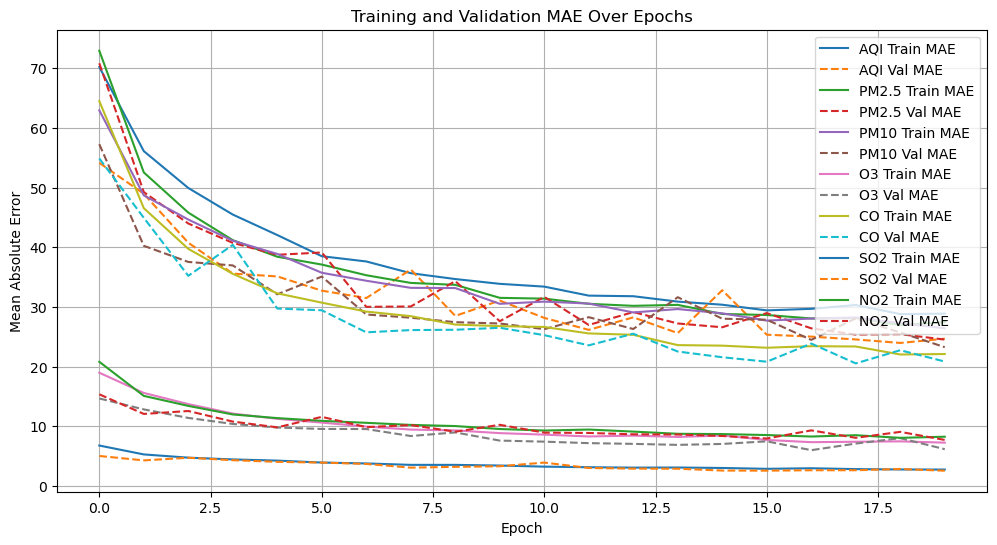


Evaluating on test data (samples: 2122)
AQI - Test MSE: 1244.3939, Test MAE: 24.6589, R²: 0.8925
PM2.5 - Test MSE: 1475.7043, Test MAE: 24.5145, R²: 0.9128
PM10 - Test MSE: 1202.2458, Test MAE: 23.2432, R²: 0.8992
O3 - Test MSE: 109.4408, Test MAE: 6.1438, R²: 0.9012
CO - Test MSE: 1138.9397, Test MAE: 20.8310, R²: 0.9202
SO2 - Test MSE: 14.8927, Test MAE: 2.5334, R²: 0.8438
NO2 - Test MSE: 167.8674, Test MAE: 7.6930, R²: 0.8563

Predicting for a new image:
Predicted AQI: 130.6811
Predicted PM2.5: 42.3850
Predicted PM10: 104.1796
Predicted O3: 24.3937
Predicted CO: 1.5735
Predicted SO2: 7.6469
Predicted NO2: 5.3787


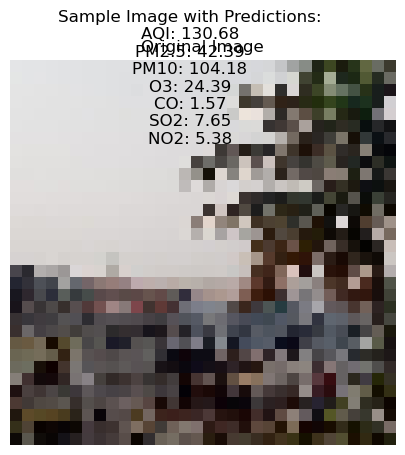

In [1]:
# Cell 1: Imports (remains unchanged)
import pandas as pd
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from functools import lru_cache
import matplotlib.pyplot as plt
#%matplotlib inline  # For inline plotting in Jupyter

iMAGE_PIXEL = 32
BATCH_SIZE = 16

@lru_cache(maxsize=100000)
def load_and_preprocess_image(image_path):
    """Load and preprocess an image, cached by file path."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (iMAGE_PIXEL, iMAGE_PIXEL))

def load_images_with_data(image_dir="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder",
                         csv_file="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_data.csv"):
    """Load images and data with caching."""
    df = pd.read_csv(csv_file)
    image_data_list = []
    
    for _, row in df.iterrows():
        image_name = row['Filename']
        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
            try:
                img_resized = load_and_preprocess_image(image_path)
                values = row.to_dict()
                values['image'] = img_resized
                image_data_list.append(values)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
        else:
            print(f"Warning: Image '{image_name}' not found in '{image_dir}'.")
    return image_data_list

# Load data
image_data_list = load_images_with_data()
print(f"Loaded {len(image_data_list)} images")

def prepare_dataset(image_data_list):
    """Prepare dataset with caching, using whole image."""
    X = []
    y_dict = {'AQI': [], 'PM2.5': [], 'PM10': [], 'O3': [], 'CO': [], 'SO2': [], 'NO2': []}
    
    for data in image_data_list:
        img = preprocess_input(data['image'])  # Use whole image directly
        X.append(img)
        for param in y_dict.keys():
            y_dict[param].append(data[param])
    
    return np.array(X), {k: np.array(v) for k, v in y_dict.items()}

# Prepare dataset
X, y_dict = prepare_dataset(image_data_list)
print(f"Dataset shape: X={X.shape}, y_dict keys={list(y_dict.keys())}")

def build_cnn_model(input_shape=(iMAGE_PIXEL, iMAGE_PIXEL, 3)):
    """Build the CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Example model summary
model = build_cnn_model()
model.summary()

def train_models(X, y_dict):
    """Train models for each parameter and report data counts."""
    models = {}
    histories = {}
    
    for param, y_values in y_dict.items():
        print(f"\nTraining model for {param}")
        X_train, X_test, y_train, y_test = train_test_split(X, y_values, test_size=0.2, random_state=42)
        print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        model = build_cnn_model()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                           epochs=20, batch_size=BATCH_SIZE, verbose=1)
        models[param] = model
        histories[param] = history
    return models, histories

# Train models
models, histories = train_models(X, y_dict)

# Plot MAE for each parameter
plt.figure(figsize=(12, 6))
for param, history in histories.items():
    plt.plot(history.history['mae'], label=f'{param} Train MAE')
    plt.plot(history.history['val_mae'], label=f'{param} Val MAE', linestyle='--')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

def test_model(models, X_test=None, y_test_dict=None, new_image_path=None):
    """Test models with MSE, MAE, R², and data counts."""
    results = {}
    
    if X_test is not None and y_test_dict is not None:
        print(f"\nEvaluating on test data (samples: {X_test.shape[0]})")
        for param, model in models.items():
            test_loss, test_mae = model.evaluate(X_test, y_test_dict[param], verbose=0)
            y_pred = model.predict(X_test, verbose=0).flatten()
            r2 = r2_score(y_test_dict[param], y_pred)
            results[param] = {'MSE': test_loss, 'MAE': test_mae, 'R²': r2}
            print(f"{param} - Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}, R²: {r2:.4f}")
    
    elif new_image_path is not None:
        print("\nPredicting for a new image:")
        img_resized = load_and_preprocess_image(new_image_path)
        img_processed = preprocess_input(img_resized)  # Use whole image
        img_processed = np.expand_dims(img_processed, axis=0)
        
        for param, model in models.items():
            pred = model.predict(img_processed, verbose=0)[0][0]
            results[param] = pred
            print(f"Predicted {param}: {pred:.4f}")
    
    else:
        raise ValueError("Provide either test data or new_image_path")
    return results

# Split data for testing
X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}
for param, y_values in y_dict.items():
    X_train[param], X_test[param], y_train_dict[param], y_test_dict[param] = train_test_split(
        X, y_values, test_size=0.2, random_state=42
    )

# Evaluate on test data
test_results = test_model(models, X_test['AQI'], y_test_dict)

# Predict for a new image
new_image = "F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder/BRI_Un_2023-02-02- 12.00-9.jpg"
pred_results = test_model(models, new_image_path=new_image)

# Display the image and its predictions
img = load_and_preprocess_image(new_image)

plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.suptitle("Sample Image with Predictions:\n" + 
             "\n".join(f"{param}: {value:.2f}" for param, value in pred_results.items()))
plt.show()